In [ ]:
import pandas as pd
import numpy as np
import matplotlib


In [ ]:
df = pd.read_csv("LivreDA.csv", on_bad_lines='warn', sep=";")

In [ ]:
print(df.isnull().sum())


bookID                    0
title                     0
authors                   0
average_rating            0
isbn                      0
language_code             0
  num_pages               0
ratings_count             0
text_reviews_count        0
publication_date          0
publisher                 0
Unnamed: 11           11071
dtype: int64


Adding new column that represents autors

In [ ]:
author_counts = df['authors'].value_counts().to_dict()
df['author_popularity'] = df['authors'].map(author_counts)

In [ ]:
df

,bookID,title,authors,average_rating,isbn,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,Unnamed: 11,author_popularity
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,439785960,eng,652,2095690,27591,9/16/2006,Scholastic Inc.,NaN,6
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,439358078,eng,870,2153167,29221,09/01/2004,Scholastic Inc.,NaN,6
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,439554896,eng,352,6333,244,11/01/2003,Scholastic,NaN,11
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,43965548,eng,435,2339585,36325,05/01/2004,Scholastic Inc.,NaN,6
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,439682584,eng,2690,41428,164,9/13/2004,Scholastic,NaN,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11066,45631,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,1560254416,eng,512,156,20,12/21/2004,Da Capo Press,NaN,1
11067,45633,You Bright and Risen Angels,William T. Vollmann,4.08,140110879,eng,635,783,56,12/01/1988,Penguin Books,NaN,5
11068,45634,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,140131965,eng,415,820,95,08/01/1993,Penguin Books,NaN,5
11069,45639,Poor People,William T. Vollmann,3.72,60878827,eng,434,769,139,2/27/2007,Ecco,NaN,5


Some general statistics to have an idea about the dataset

In [ ]:
# Descriptive Statistics
statistiques_descriptives = df.describe()
print(statistiques_descriptives)

             bookID  average_rating     num_pages  ratings_count  \
count  11071.000000    11071.000000  11071.000000   1.107100e+04   
mean   21295.243700        3.933449    336.268539   1.788554e+04   
std    13098.987103        0.350772    241.164263   1.127226e+05   
min        1.000000        0.000000      0.000000   0.000000e+00   
25%    10266.000000        3.770000    192.000000   1.030000e+02   
50%    20237.000000        3.960000    299.000000   7.380000e+02   
75%    32082.500000        4.130000    416.000000   4.930500e+03   
max    45641.000000        5.000000   6576.000000   4.597666e+06   

       text_reviews_count  Unnamed: 11  
count        11071.000000          0.0  
mean           541.203234          NaN  
std           2581.875190          NaN  
min              0.000000          NaN  
25%              9.000000          NaN  
50%             46.000000          NaN  
75%            235.000000          NaN  
max          94265.000000          NaN  


In [ ]:
# Books with higher average ratings
livres_meilleures_notes = df.nlargest(5, 'average_rating')[['title', 'authors', 'average_rating']]
print("Livres avec les meilleures notes:\n", livres_meilleures_notes)

Livres avec les meilleures notes:
                                                   title  \
621   Comoediae 1: Acharenses/Equites/Nubes/Vespae/P...   
782                   Willem de Kooning: Late Paintings   
851   Literature Circle Guide: Bridge to Terabithia:...   
1237  Middlesex Borough (Images of America: New Jersey)   
4114  Zone of the Enders: The 2nd Runner Official St...   

                                   authors  average_rating  
621    Aristophanes/F.W. Hall/W.M. Geldart             5.0  
782        Julie Sylvester/David Sylvester             5.0  
851                         Tara MacCarthy             5.0  
1237  Middlesex Borough Heritage Committee             5.0  
4114                            Tim Bogenn             5.0  


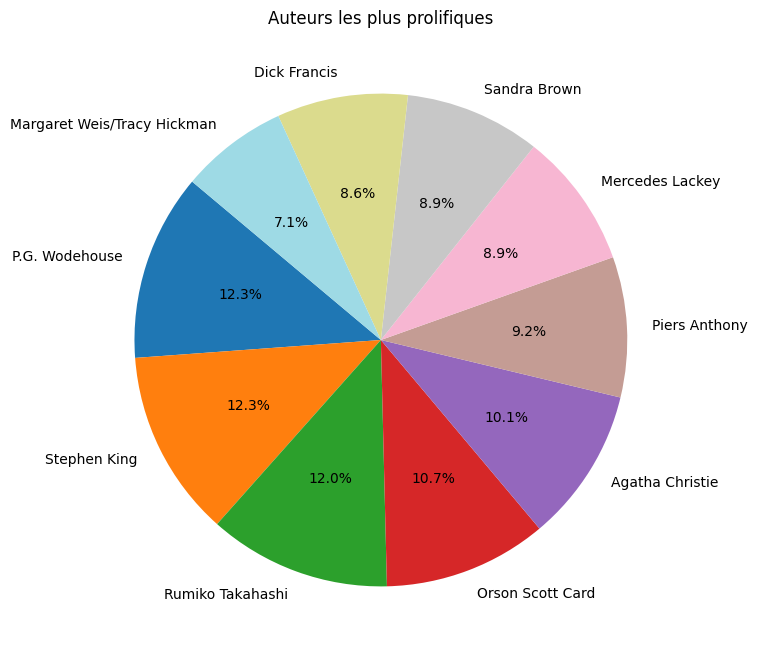

In [ ]:
import matplotlib.pyplot as plt

# Couting books by author
auteurs_prolifiques = df['authors'].value_counts().head(10)
plt.figure(figsize=(10, 8))
auteurs_prolifiques.plot.pie(autopct='%1.1f%%', startangle=140, cmap='tab20')
plt.title('Auteurs les plus prolifiques')
plt.ylabel('')
plt.show()


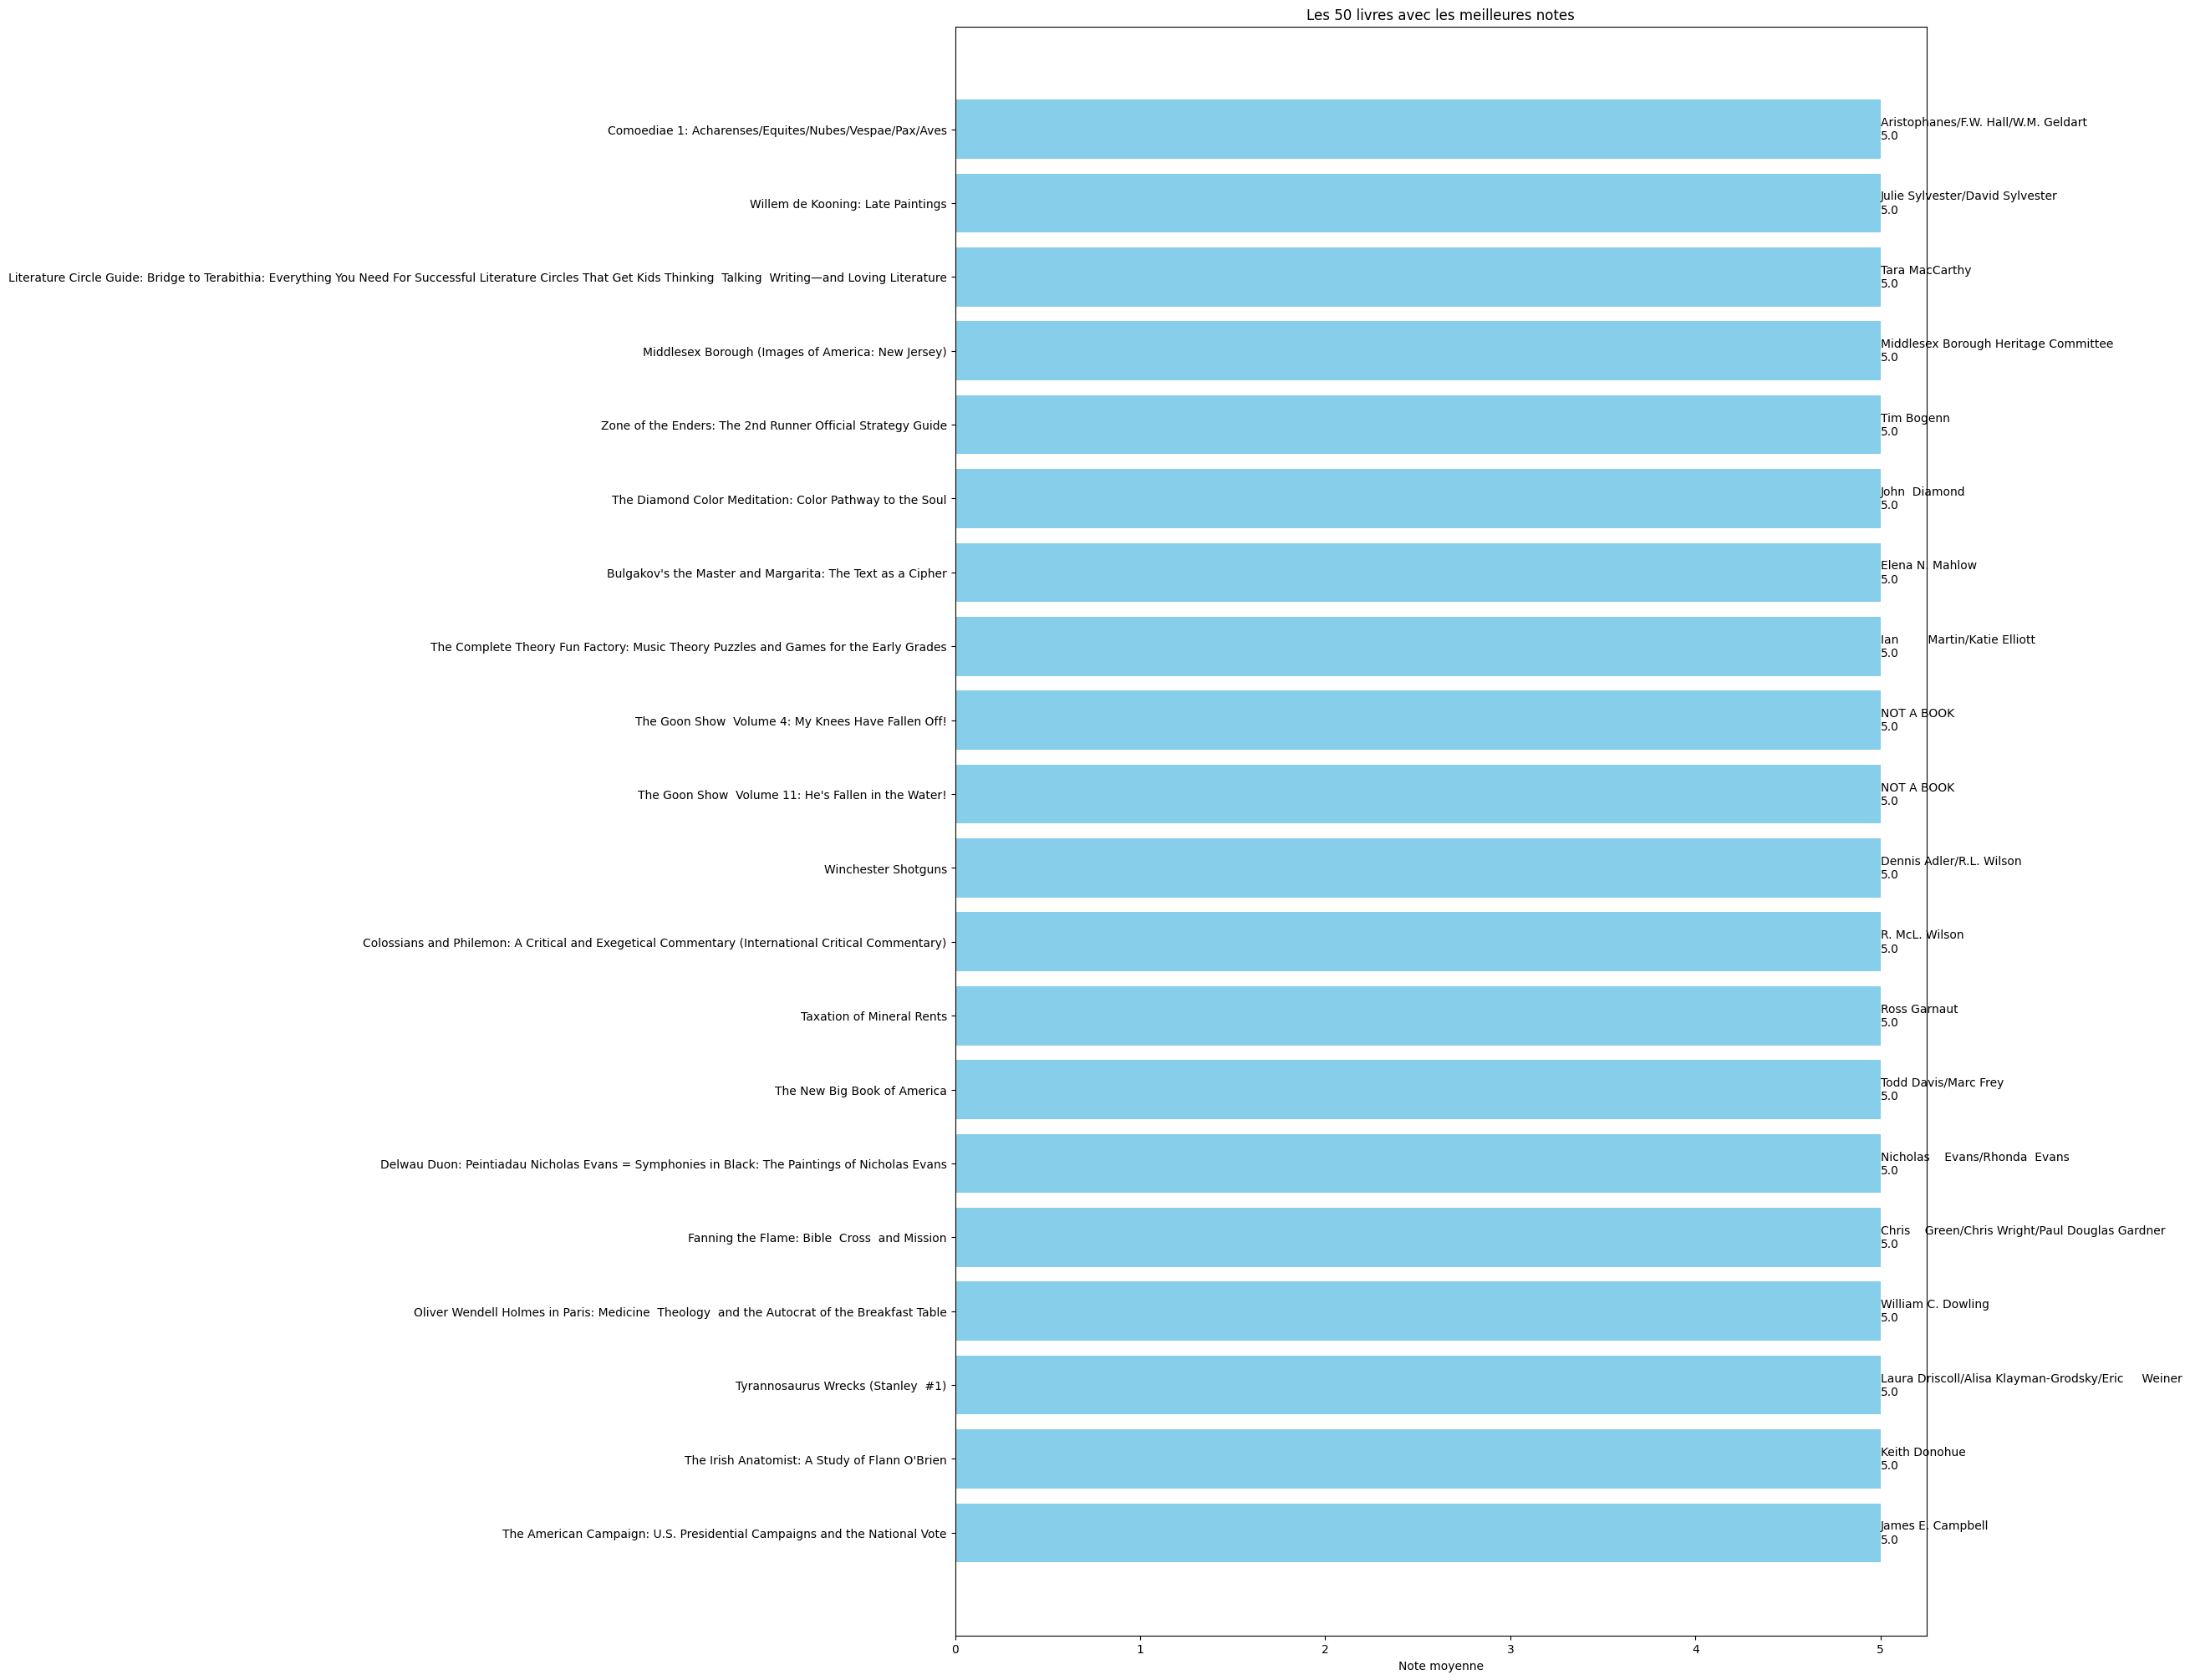

In [ ]:

livres_meilleures_notes = df.nlargest(20, 'average_rating')[['title', 'authors', 'average_rating']]

plt.figure(figsize=(15, 25))
bars = plt.barh(livres_meilleures_notes['title'], livres_meilleures_notes['average_rating'], color='skyblue')


for bar, author, rating in zip(bars, livres_meilleures_notes['authors'], livres_meilleures_notes['average_rating']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{author}\n{rating}', ha='left', va='center', color='black')


plt.xlabel('Note moyenne')
plt.title('Les 50 livres avec les meilleures notes')
plt.gca().invert_yaxis()

plt.show()

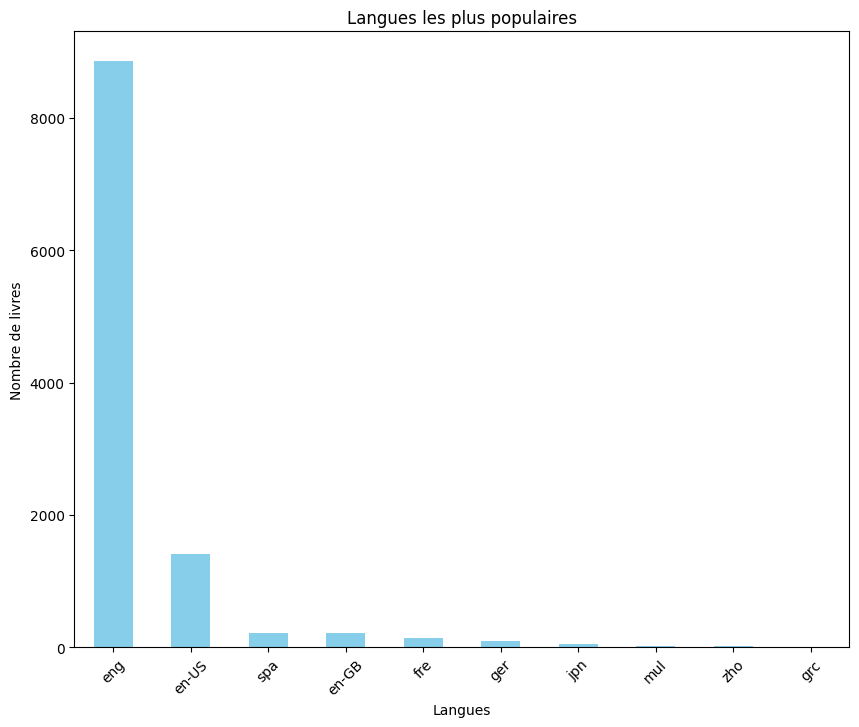

In [ ]:

# Distribution des langues
langues_prolifiques = df['language_code'].value_counts().head(10)

plt.figure(figsize=(10, 8))
langues_prolifiques.plot(kind='bar', color='skyblue')
plt.title('Langues les plus populaires')
plt.xlabel('Langues')
plt.ylabel('Nombre de livres')
plt.xticks(rotation=45)
plt.show()


The books in english are over represented in our dataset

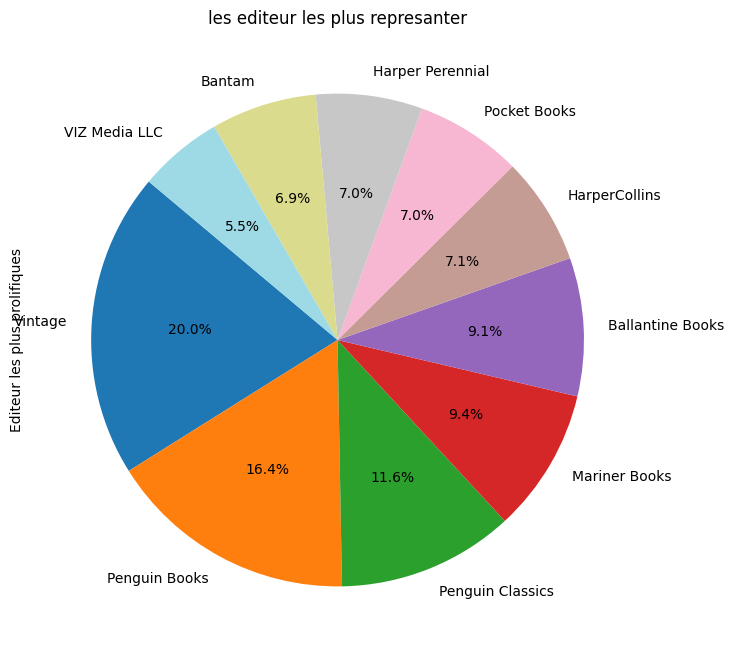

In [ ]:

genres_prolifiques = df['publisher'].value_counts().head(10)
plt.figure(figsize=(10, 8))
genres_prolifiques.plot.pie(autopct='%1.1f%%', startangle=140, cmap='tab20')
plt.title('les editeur les plus represanter')
plt.ylabel('Editeur les plus prolifiques')
plt.show()


Visualisation de la répartition des notes

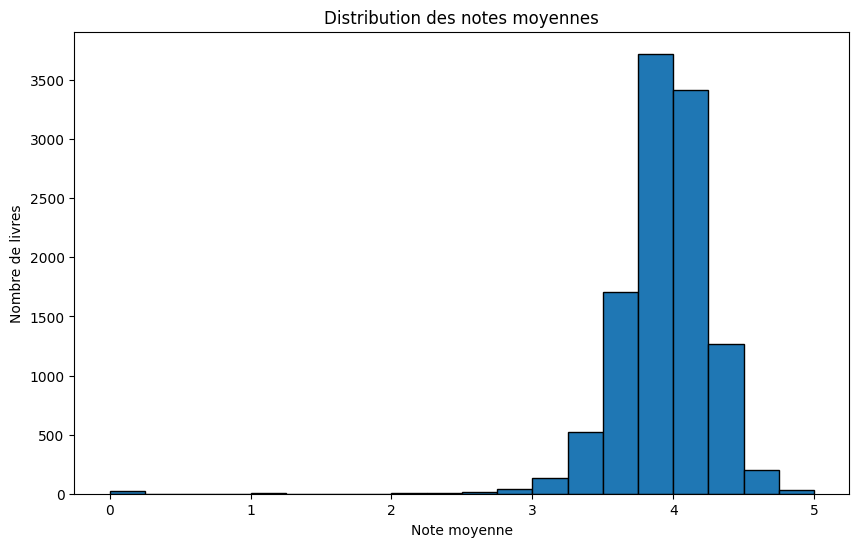

In [ ]:
# Histogramme des notes moyennes
plt.figure(figsize=(10, 6))
df['average_rating'].hist(bins=20, edgecolor='black')
plt.title('Distribution des notes moyennes')
plt.xlabel('Note moyenne')
plt.ylabel('Nombre de livres')
plt.grid(False)
plt.show()

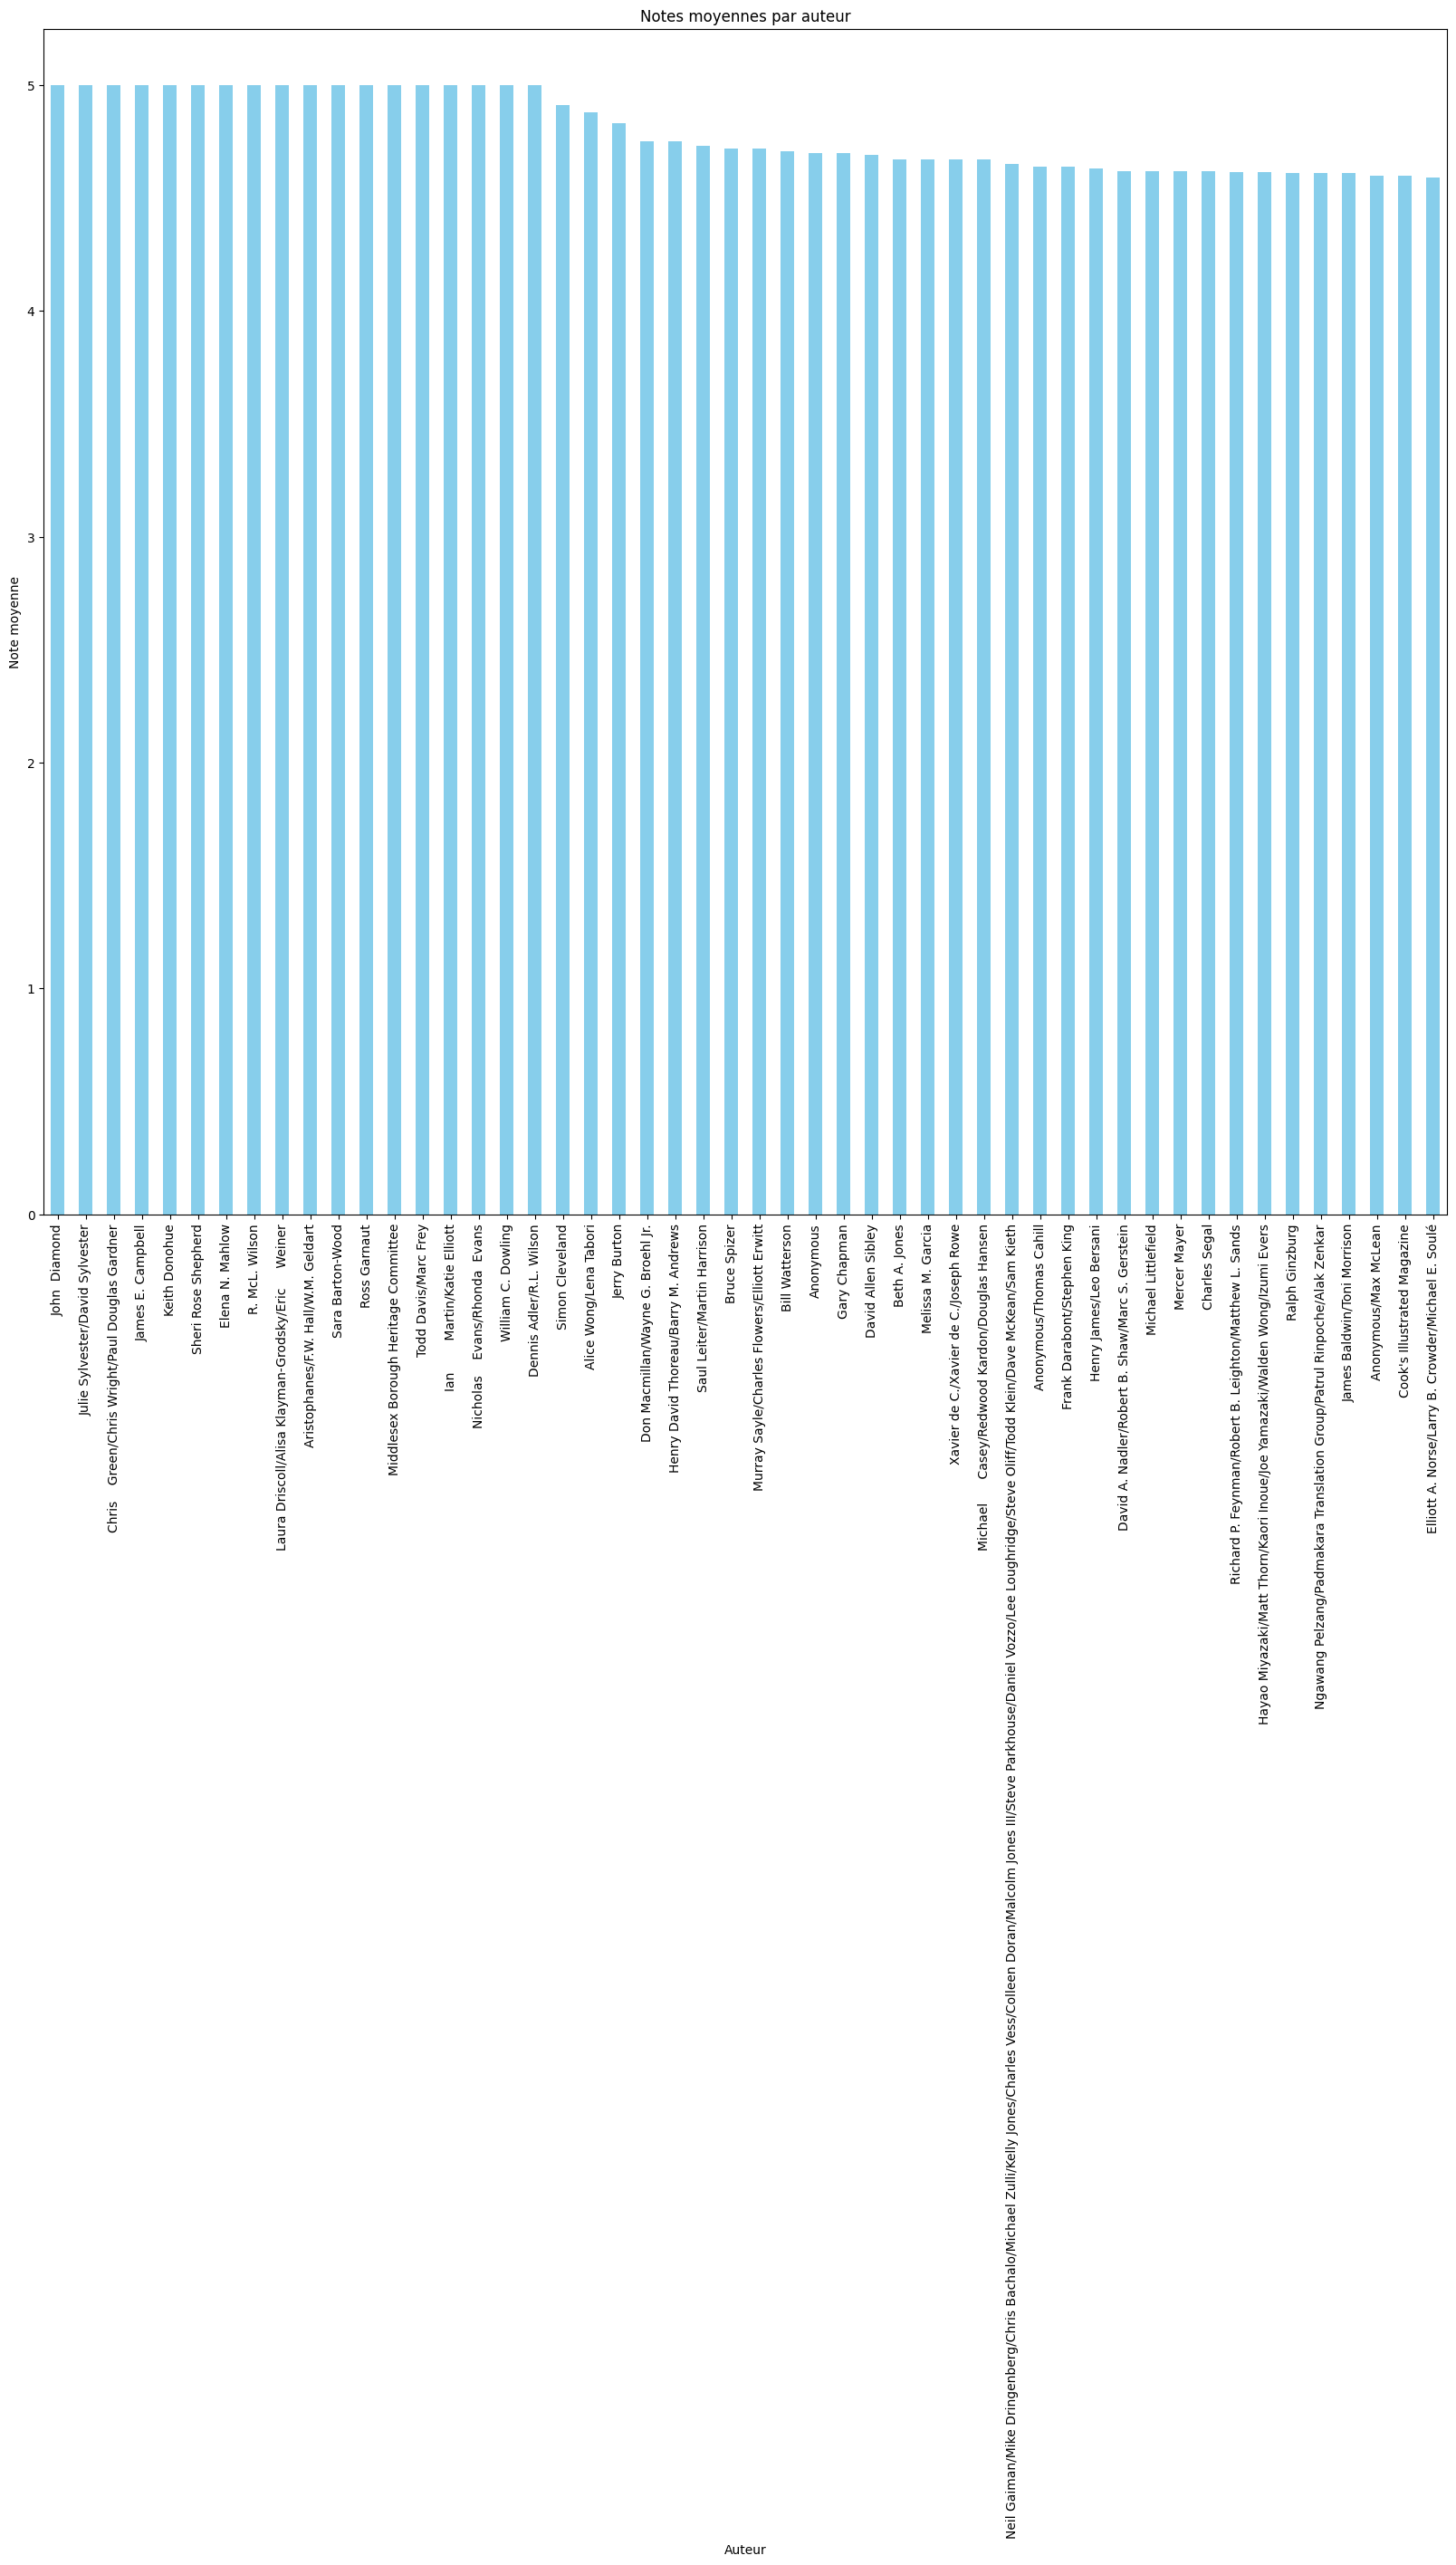

In [ ]:
# Calculer la moyenne des notes pour les 50 auteurs les plus prolifiques
auteurs_moyenne_notes = df.groupby('authors')['average_rating'].mean().sort_values(ascending=False).head(50)

plt.figure(figsize=(20, 17))
auteurs_moyenne_notes.plot(kind='bar', color='skyblue')
plt.title('Notes moyennes par auteur')
plt.xlabel('Auteur')
plt.ylabel('Note moyenne')
plt.xticks(rotation=90)
plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30343 (\N{CJK UNIFIED IDEOGRAPH-7687}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20896 (\N{CJK UNIFIED IDEOGRAPH-51A0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25991 (\N{CJK UNIFIED IDEOGRAPH-6587}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20986 (\N{CJK UNIFIED IDEOGRAPH-51FA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

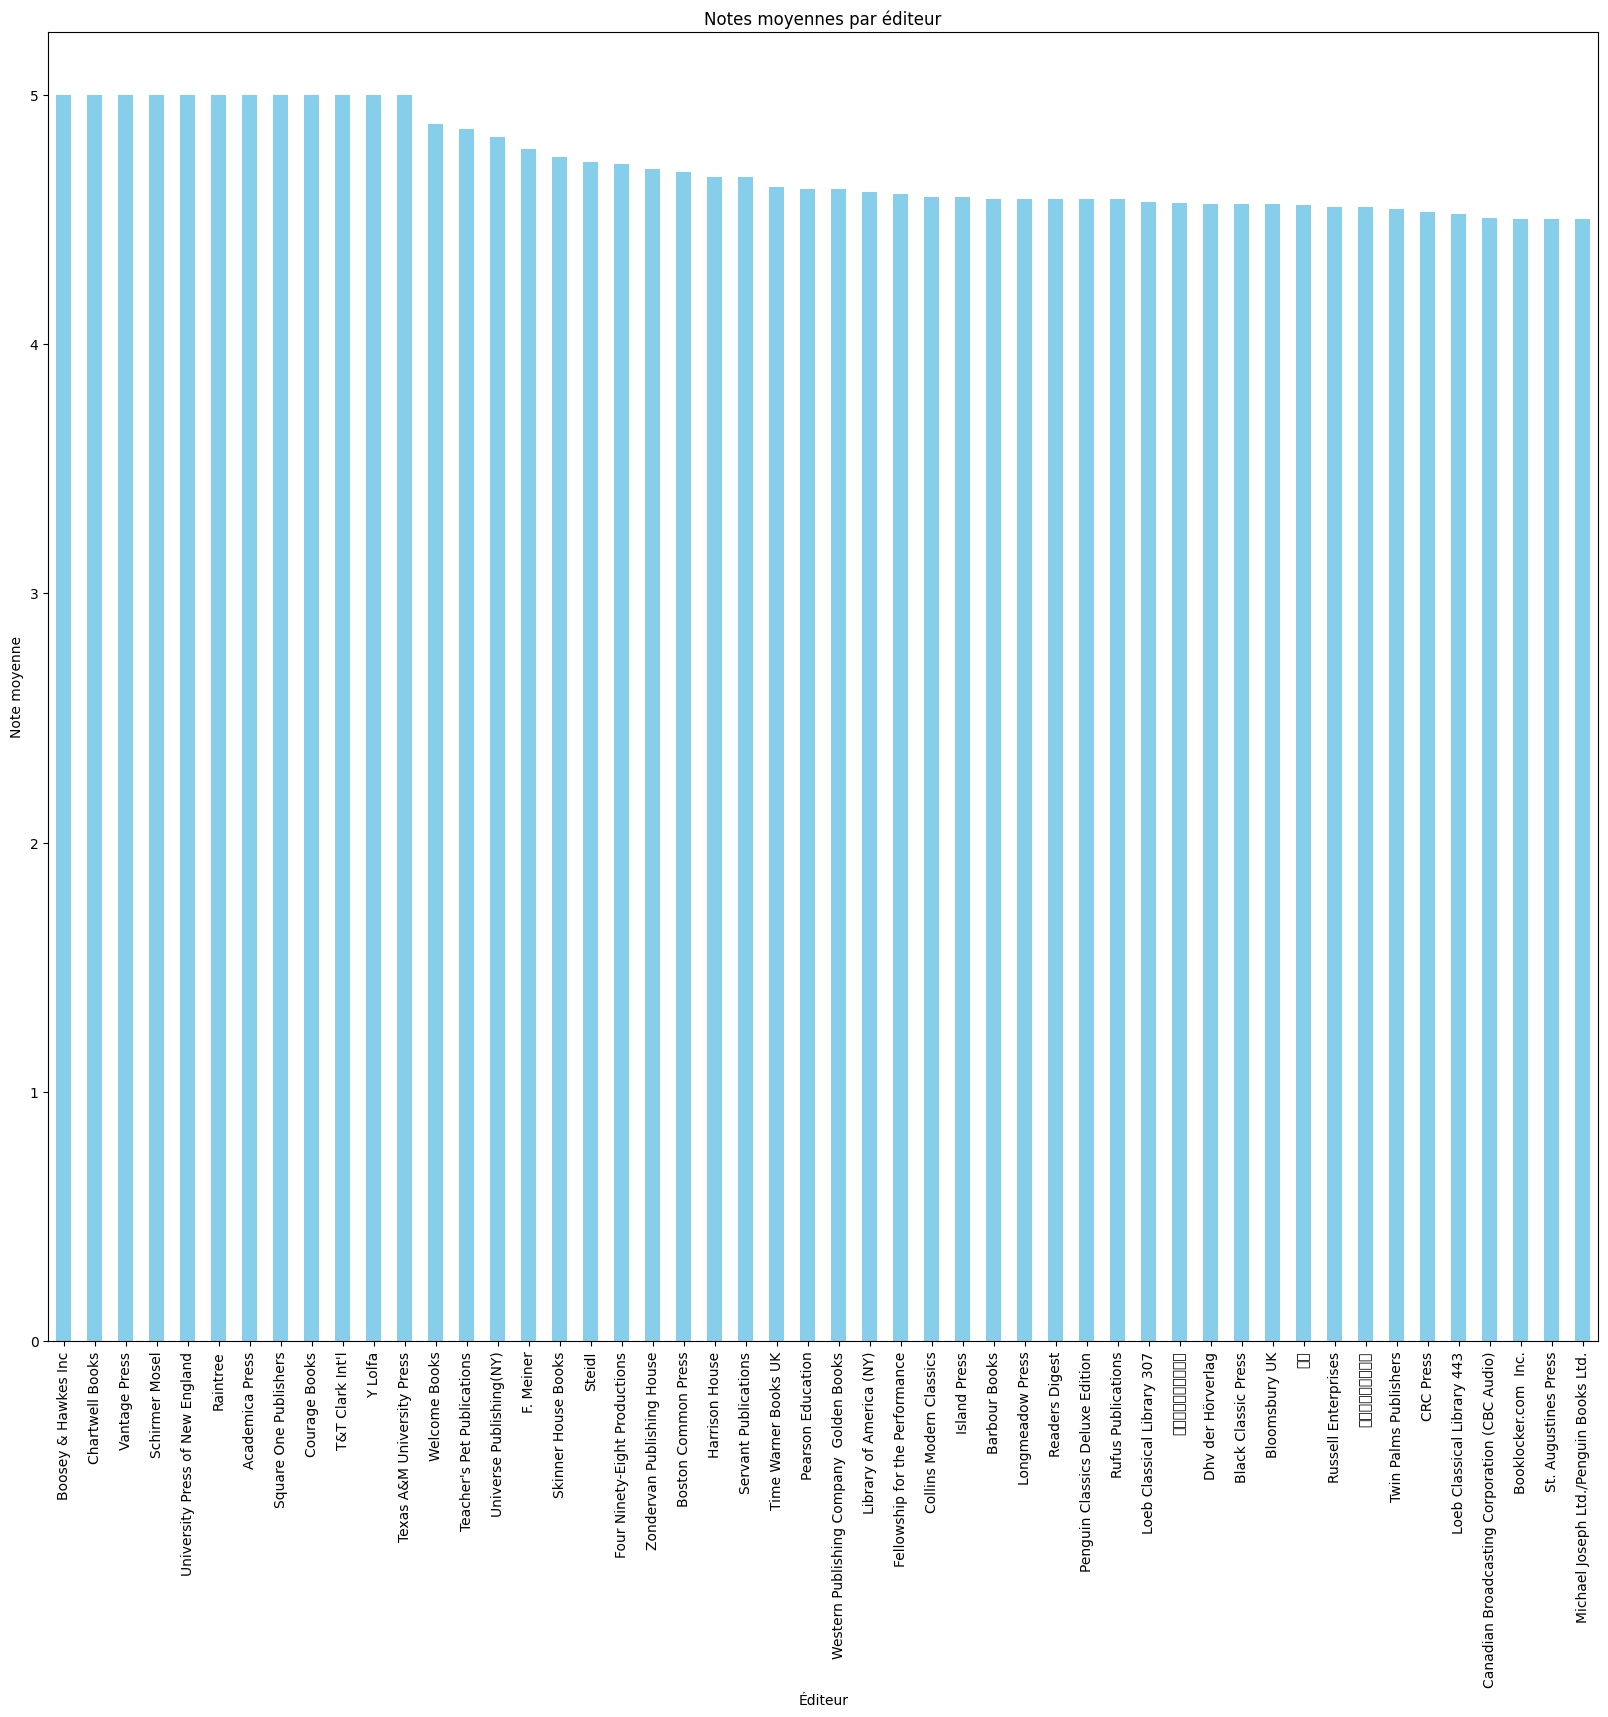

,count,mean,std,min,25%,50%,75%,max
publisher,,,,,,,,
Boosey & Hawkes Inc,1.0,5.00000,NaN,5.00,5.0000,5.000,5.0000,5.00
Chartwell Books,1.0,5.00000,NaN,5.00,5.0000,5.000,5.0000,5.00
Vantage Press,1.0,5.00000,NaN,5.00,5.0000,5.000,5.0000,5.00
Schirmer Mosel,1.0,5.00000,NaN,5.00,5.0000,5.000,5.0000,5.00
University Press of New England,1.0,5.00000,NaN,5.00,5.0000,5.000,5.0000,5.00
Raintree,1.0,5.00000,NaN,5.00,5.0000,5.000,5.0000,5.00
Academica Press,1.0,5.00000,NaN,5.00,5.0000,5.000,5.0000,5.00
Square One Publishers,1.0,5.00000,NaN,5.00,5.0000,5.000,5.0000,5.00
Courage Books,1.0,5.00000,NaN,5.00,5.0000,5.000,5.0000,5.00


In [ ]:
# Calculer la moyenne des notes pour les éditeurs les plus prolifiques
editeurs_moyenne_notes = df.groupby('publisher')['average_rating'].mean().sort_values(ascending=False).head(50)


plt.figure(figsize=(20, 17))
editeurs_moyenne_notes.plot(kind='bar', color='skyblue')
plt.title('Notes moyennes par éditeur')
plt.xlabel('Éditeur')
plt.ylabel('Note moyenne')
plt.xticks(rotation=90)
plt.show()


editeurs_stats = df.groupby('publisher')['average_rating'].describe().sort_values(by='mean', ascending=False).head(50)

editeurs_stats

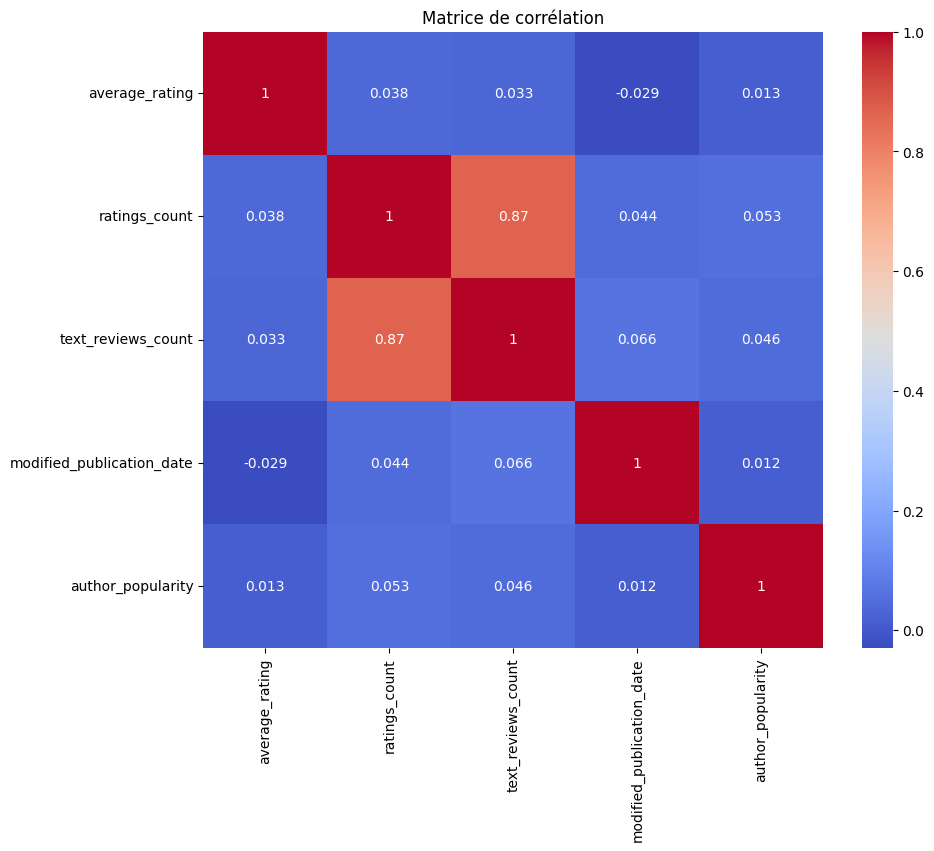

In [ ]:
# Calcul de la matrice de corrélation pour les caractéristiques numériques
correlation_matrix = df[['average_rating', 'ratings_count', 'text_reviews_count', "modified_publication_date", 'author_popularity']].corr()

# Affichage de la matrice de corrélation
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matrice de corrélation')
plt.show()
# A noter les conrrélation sont très basses

We can see that average rating does not have a big correlation with any of the numerical columns

In [ ]:
# Converttinh the string column to datetime with error handling and create a new column for modified dates
df['modified_publication_date'] = pd.to_datetime(df['publication_date'], format="%m/%d/%Y", errors='coerce')

# Parsing different date formats
formats = ["%m/%d/%Y", "%d/%m/%Y"]
for fmt in formats:
    temp_dates = pd.to_datetime(df['publication_date'], format=fmt, errors='coerce')
    df['modified_publication_date'] = df['modified_publication_date'].combine_first(temp_dates)

In [ ]:
df['publication_year'] = pd.to_datetime(df['modified_publication_date']).dt.year.astype(int)

In [ ]:
import datetime
df.at[8146, 'modified_publication_date'] = datetime.datetime(2000, 11, 30)

In [ ]:
df[df['publication_year'].isna()]

,bookID,title,authors,average_rating,isbn,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,Unnamed: 11,author_popularity,modified_publication_date,publication_year
8146,31373,In Pursuit of the Proper Sinner (Inspector Lyn...,Elizabeth George,4.10,553575104,eng,718,10608,295,11/31/2000,Bantam Books,NaN,4,NaT,NaN
11042,45531,Montaillou village occitan de 1294 à 1324,Emmanuel Le Roy Ladurie/Emmanuel Le Roy-Ladurie,3.96,2070323285,fre,640,15,2,6/31/1982,Folio histoire,NaN,1,NaT,NaN


In [ ]:
df['modified_publication_date']

0       2006-09-16
1       2004-09-01
2       2003-11-01
3       2004-05-01
4       2004-09-13
           ...    
11066   2004-12-21
11067   1988-12-01
11068   1993-08-01
11069   2007-02-27
11070   2006-05-28
Name: modified_publication_date, Length: 11071, dtype: datetime64[ns]

In [ ]:
df.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'language_code',
       '  num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher', 'Unnamed: 11',
       'modified_publication_date'],
      dtype='object')

In [ ]:
train_data = df.copy()

In [ ]:
train_data.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'language_code',
       '  num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher', 'Unnamed: 11', 'author_popularity',
       'modified_publication_date', 'publication_year'],
      dtype='object')

In [1]:
# we are only keeping the year and dropping the date

In [ ]:
train_data=train_data.drop(['publication_date'], axis=1)

In [ ]:
train_data.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'language_code',
       '  num_pages', 'ratings_count', 'text_reviews_count', 'publisher',
       'author_popularity', 'modified_publication_date', 'publication_year'],
      dtype='object')

In [ ]:
train_data['publisher_freq'] = train_data['publisher'].map(train_data['publisher'].value_counts()) / len(train_data)

In [ ]:
train_data['publisher_freq']

0        0.001174
1        0.001174
2        0.002981
3        0.001174
4        0.002981
           ...   
11066    0.001897
11067    0.023485
11068    0.023485
11069    0.001716
11070    0.000361
Name: publisher_freq, Length: 11071, dtype: float64

In [3]:
# After adding numerical columns that represent the non numerical ones we compute the correlation matrix again to see 
#if can have a columns that is better correlated 
#to the average rating

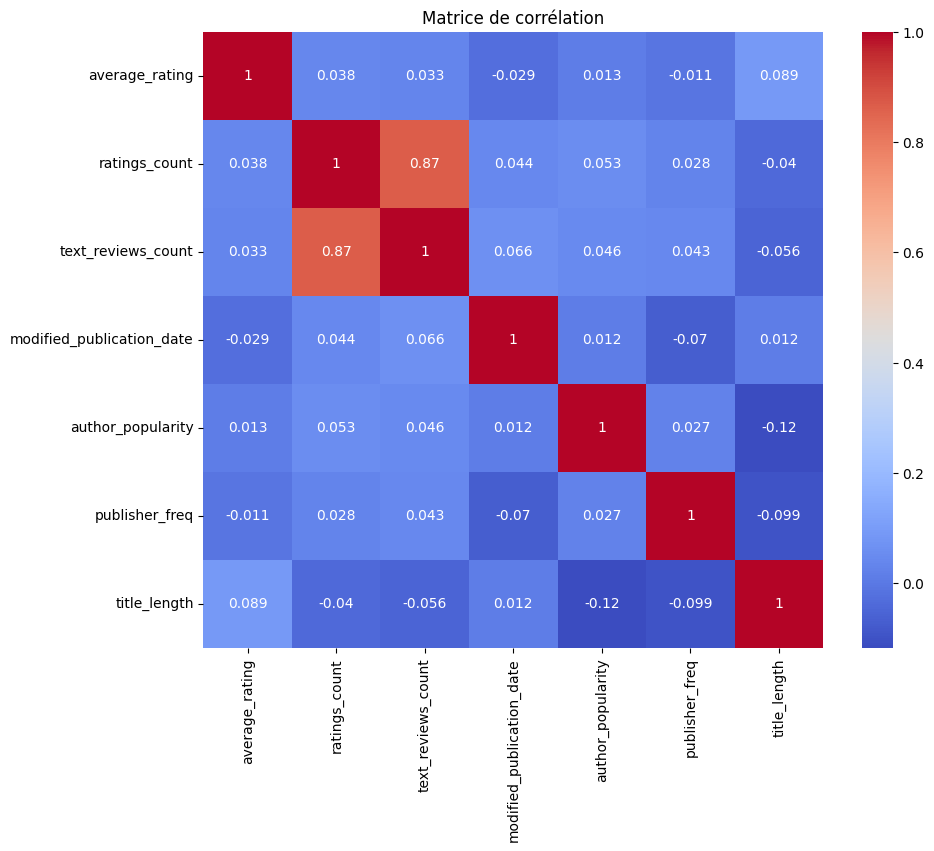

In [ ]:
correlation_matrix = train_data_2[['average_rating', 'ratings_count', 'text_reviews_count', "modified_publication_date", 'author_popularity','publisher_freq','title_length']].corr()

# Affichage de la matrice de corrélation
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matrice de corrélation')
plt.show()
# matrice de corrélation avec l'ajout de nouvel colonnes "modified_publication_date", 'author_popularity','publisher_freq','title_length'
# Les corrélations toujours basses

In [4]:
# we can see that best correlation we have is 0.089 with title length which is not very good

In [ ]:
train_data.language_code.unique()

array(['eng', 'en-US', 'fre', 'spa', 'en-GB', 'mul', 'grc', 'enm',
       'en-CA', 'ger', 'jpn', 'ara', 'nl', 'zho', 'lat', 'por', 'ita',
       'rus', 'msa', 'glg', 'wel', 'swe', 'nor', 'tur', 'gla', 'ale'],
      dtype=object)

In [ ]:
# Création d'une copie pour l'entrainement
train_data_2 = train_data.copy()

In [ ]:
# One-hot encoding for language_code
train_data_2 = pd.get_dummies(train_data_2, columns=['language_code'], drop_first=True)

In [ ]:
train_data_2.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', '  num_pages',
       'ratings_count', 'text_reviews_count', 'publisher', 'author_popularity',
       'modified_publication_date', 'publication_year', 'publisher_freq',
       'language_code_ara', 'language_code_en-CA', 'language_code_en-GB',
       'language_code_en-US', 'language_code_eng', 'language_code_enm',
       'language_code_fre', 'language_code_ger', 'language_code_gla',
       'language_code_glg', 'language_code_grc', 'language_code_ita',
       'language_code_jpn', 'language_code_lat', 'language_code_msa',
       'language_code_mul', 'language_code_nl', 'language_code_nor',
       'language_code_por', 'language_code_rus', 'language_code_spa',
       'language_code_swe', 'language_code_tur', 'language_code_wel',
       'language_code_zho'],
      dtype='object')

In [ ]:
train_data_2['title_length'] = train_data_2['title'].apply(len)

In [ ]:
train_data_2

,bookID,title,authors,average_rating,isbn,num_pages,ratings_count,text_reviews_count,publisher,author_popularity,...,language_code_mul,language_code_nl,language_code_nor,language_code_por,language_code_rus,language_code_spa,language_code_swe,language_code_tur,language_code_wel,language_code_zho
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,439785960,652,2095690,27591,Scholastic Inc.,6,...,False,False,False,False,False,False,False,False,False,False
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,439358078,870,2153167,29221,Scholastic Inc.,6,...,False,False,False,False,False,False,False,False,False,False
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,439554896,352,6333,244,Scholastic,11,...,False,False,False,False,False,False,False,False,False,False
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,43965548,435,2339585,36325,Scholastic Inc.,6,...,False,False,False,False,False,False,False,False,False,False
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,439682584,2690,41428,164,Scholastic,6,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11066,45631,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,1560254416,512,156,20,Da Capo Press,1,...,False,False,False,False,False,False,False,False,False,False
11067,45633,You Bright and Risen Angels,William T. Vollmann,4.08,140110879,635,783,56,Penguin Books,5,...,False,False,False,False,False,False,False,False,False,False
11068,45634,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,140131965,415,820,95,Penguin Books,5,...,False,False,False,False,False,False,False,False,False,False
11069,45639,Poor People,William T. Vollmann,3.72,60878827,434,769,139,Ecco,5,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
train_data_2.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', '  num_pages',
       'ratings_count', 'text_reviews_count', 'publisher', 'author_popularity',
       'modified_publication_date', 'publication_year', 'publisher_freq',
       'language_code_ara', 'language_code_en-CA', 'language_code_en-GB',
       'language_code_en-US', 'language_code_eng', 'language_code_enm',
       'language_code_fre', 'language_code_ger', 'language_code_gla',
       'language_code_glg', 'language_code_grc', 'language_code_ita',
       'language_code_jpn', 'language_code_lat', 'language_code_msa',
       'language_code_mul', 'language_code_nl', 'language_code_nor',
       'language_code_por', 'language_code_rus', 'language_code_spa',
       'language_code_swe', 'language_code_tur', 'language_code_wel',
       'language_code_zho'],
      dtype='object')

In [ ]:
train_data_2['publication_month'] = pd.to_datetime(train_data_2['modified_publication_date']).dt.month.astype(int)

In [ ]:
train_data_2['publication_month'].isna().sum()

0

In [ ]:
from sklearn.preprocessing import StandardScaler

numerical_features = ['  num_pages', 'ratings_count', 'text_reviews_count', 'title_length', 'author_popularity', 'publication_year','publication_month']
scaler = StandardScaler()
train_data_2[numerical_features] = scaler.fit_transform(train_data_2[numerical_features])


In [ ]:
from sklearn.model_selection import train_test_split
# we only keep numerical columns for the training
X = train_data_2.drop(columns=['bookID', 'title', 'authors', 'average_rating', 'isbn', 'modified_publication_date','publisher'])
y = train_data_2['average_rating']
# we are splitting the data set to 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
X

,num_pages,ratings_count,text_reviews_count,author_popularity,publication_year,publisher_freq,language_code_ara,language_code_en-CA,language_code_en-GB,language_code_en-US,...,language_code_nor,language_code_por,language_code_rus,language_code_spa,language_code_swe,language_code_tur,language_code_wel,language_code_zho,publication_month,title_length
0,1.309256,18.433737,10.477276,0.186029,0.707613,0.001174,False,False,False,False,...,False,False,False,False,False,False,False,False,0.719829,0.904718
1,2.213245,18.943658,11.108628,0.186029,0.465472,0.001174,False,False,False,False,...,False,False,False,False,False,False,False,False,0.719829,1.031916
2,0.065234,-0.102491,-0.115117,0.925960,0.344402,0.002981,False,False,False,False,...,False,False,False,False,False,False,False,False,1.305801,0.947117
3,0.409414,20.597510,13.860241,0.186029,0.465472,0.001174,False,False,False,False,...,False,False,False,False,False,False,False,False,-0.452116,0.989516
4,9.760309,0.208863,-0.146103,0.186029,0.465472,0.002981,False,False,False,False,...,False,False,False,False,False,False,False,False,0.719829,0.777520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11066,0.728712,-0.157292,-0.201879,-0.553903,0.465472,0.001897,False,False,False,False,...,False,False,False,False,False,False,False,False,1.598787,0.523123
11067,1.238761,-0.151729,-0.187935,0.038043,-1.471655,0.023485,False,False,False,False,...,False,False,False,False,False,False,False,False,1.598787,-0.367263
11068,0.326479,-0.151401,-0.172829,0.038043,-0.866303,0.023485,False,False,False,False,...,False,False,False,False,False,False,False,False,0.426843,-0.197666
11069,0.405267,-0.151853,-0.155787,0.038043,0.828683,0.001716,False,False,False,False,...,False,False,False,False,False,False,False,False,-1.331074,-1.045653


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Trainning the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predicting
y_pred_train = lr_model.predict(X_train)
y_pred_test = lr_model.predict(X_test)

# Evaluation
print('Linear Regression Train RMSE:', mean_squared_error(y_train, y_pred_train, squared=False))
print('Linear Regression Test RMSE:', mean_squared_error(y_test, y_pred_test, squared=False))
print('Linear Regression Test R^2:', r2_score(y_test, y_pred_test))


Linear Regression Train RMSE: 0.3464289246499479
Linear Regression Test RMSE: 0.3279924469763651
Linear Regression Test R^2: 0.04319823448437876


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# training the random forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# using the model for prediction
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

# evaluating the model's performance
print('Random Forest Train RMSE:', mean_squared_error(y_train, y_pred_train, squared=False))
print('Random Forest Test RMSE:', mean_squared_error(y_test, y_pred_test, squared=False))
print('Random Forest Test R^2:', r2_score(y_test, y_pred_test))


Random Forest Train RMSE: 0.11695446863948991
Random Forest Test RMSE: 0.3221186815464978
Random Forest Test R^2: 0.0771606429909325


In [5]:
# we repeat the same training prediction and evaluation steps for more ml models

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

y_pred_train = gb_model.predict(X_train)
y_pred_test = gb_model.predict(X_test)

# 
print('Gradient Boosting Train RMSE:', mean_squared_error(y_train, y_pred_train, squared=False))
print('Gradient Boosting Test RMSE:', mean_squared_error(y_test, y_pred_test, squared=False))
print('Gradient Boosting Test R^2:', r2_score(y_test, y_pred_test))


Gradient Boosting Train RMSE: 0.2839680634955619
Gradient Boosting Test RMSE: 0.31541576267339255
Gradient Boosting Test R^2: 0.11516749491109513


In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

print('XGBoost Train RMSE:', mean_squared_error(y_train, y_pred_train, squared=False))
print('XGBoost Test RMSE:', mean_squared_error(y_test, y_pred_test, squared=False))
print('XGBoost Test R^2:', r2_score(y_test, y_pred_test))


XGBoost Train RMSE: 0.1810625281877104
XGBoost Test RMSE: 0.31067148610406087
XGBoost Test R^2: 0.14158544647104088


## Trying with more data cleaning (keeping only unique language codes and only books with more than 100 pages

In [ ]:
train_data_3 = train_data.copy()

In [ ]:
train_data_3['language_code'] = train_data_3['language_code'].replace({'en-US': 'eng', 'en-GB': 'eng', 'en-CA': 'eng'})


In [ ]:
train_data_3.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'language_code',
       '  num_pages', 'ratings_count', 'text_reviews_count', 'publisher',
       'author_popularity', 'modified_publication_date', 'publication_year',
       'publisher_freq'],
      dtype='object')

In [ ]:
train_data_3['publication_year'] = pd.to_datetime(train_data_3['modified_publication_date']).dt.year.astype(int)

In [ ]:
train_data_3['title_length'] = train_data_3['title'].apply(len)

In [ ]:
train_data_3 = pd.get_dummies(train_data_3, columns=['language_code'], drop_first=True)

In [ ]:
train_data_3.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', '  num_pages',
       'ratings_count', 'text_reviews_count', 'publisher', 'author_popularity',
       'modified_publication_date', 'publication_year', 'publisher_freq',
       'publication_month', 'title_length', 'language_code_ara',
       'language_code_eng', 'language_code_enm', 'language_code_fre',
       'language_code_ger', 'language_code_gla', 'language_code_glg',
       'language_code_grc', 'language_code_ita', 'language_code_jpn',
       'language_code_lat', 'language_code_msa', 'language_code_mul',
       'language_code_nl', 'language_code_nor', 'language_code_por',
       'language_code_rus', 'language_code_spa', 'language_code_swe',
       'language_code_tur', 'language_code_wel', 'language_code_zho'],
      dtype='object')

In [ ]:
# Drop rows where num_pages is less than 30
train_data_3 = train_data_3[train_data_3['  num_pages'] >= 100]

In [ ]:
from sklearn.model_selection import train_test_split

X = train_data_3.drop(columns=['bookID', 'title', 'authors', 'average_rating', 'isbn', 'modified_publication_date','publisher'])
y = train_data_3['average_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict
y_pred_train = lr_model.predict(X_train)
y_pred_test = lr_model.predict(X_test)

# Evaluate
print('Linear Regression Train RMSE:', mean_squared_error(y_train, y_pred_train, squared=False))
print('Linear Regression Test RMSE:', mean_squared_error(y_test, y_pred_test, squared=False))
print('Linear Regression Test R^2:', r2_score(y_test, y_pred_test))


Linear Regression Train RMSE: 0.3280463843367255
Linear Regression Test RMSE: 0.31432433476326355
Linear Regression Test R^2: 0.05714807279444545


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

# Evaluate
print('Random Forest Train RMSE:', mean_squared_error(y_train, y_pred_train, squared=False))
print('Random Forest Test RMSE:', mean_squared_error(y_test, y_pred_test, squared=False))
print('Random Forest Test R^2:', r2_score(y_test, y_pred_test))


Random Forest Train RMSE: 0.11443738495854983
Random Forest Test RMSE: 0.2854704353669161
Random Forest Test R^2: 0.22230419253947953


## The best R^2 we have so far is 22% that means we need to do more data cleaning and we also need to add more data or columns to our dataset that have better correlation with the average rating ~~